# 6.6 Sourcing & Analyzing Time Series Data

## This script contains the following:

### 1. Importing your libraries and data
### 2. Subsetting, wrangling, and cleaning time-series data
### 3. Time series analysis: decomposition
### 4. Testing for stationarity
### 5. Stationarizing the Federal Reserve Economic Data
### 6. Bonus task: time series forecasting model

## 01. Importing your libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate
plt.style.use('fivethirtyeight') # This is a styling option for how plots will appear.

In [2]:
# Create path
path = r'C:\Users\Quinn\Documents\CF - Data Analysis\Data Immersion\Achieve 6\AirBnB in Europe cities Project'

In [3]:
# Import the dataset
house_price = pd.read_excel(os.path.join(path, '02 Data','Original Data', 'UK_house_price.xlsx'))

#### This dataset is collected from UK Building Societies Associations, reflecting the average price of houses in the UK from 1993 to 2022
#### I chose this dataset because the price discrepancy in buying houses throughout the years can affect the rental price of AirBnb listings.

## 02. Subsetting, wrangling, and cleaning time-series data

In [4]:
house_price.head()

,Unnamed: 0,Date,Avg_price
0,NaT,1993-Jan,50075.486575
1,NaT,1993-Feb,50374.680861
2,NaT,1993-Mar,50187.356875
3,NaT,1993-Apr,51677.239161
4,NaT,1993-May,50901.094775


In [5]:
# Change the datatype in column Date to datetime
house_price['Date'] = pd.to_datetime(house_price['Date'])

In [6]:
# Drop the unnecesssary column
house_price = house_price.drop(columns = 'Unnamed: 0')

In [7]:
house_price.head()

,Date,Avg_price
0,1993-01-01,50075.486575
1,1993-02-01,50374.680861
2,1993-03-01,50187.356875
3,1993-04-01,51677.239161
4,1993-05-01,50901.094775


In [8]:
house_price.shape

(357, 2)

In [9]:
house_price.columns

Index(['Date', 'Avg_price'], dtype='object')

In [10]:
# Set the "Date" column as the index

from datetime import datetime

house_price['Datetime'] = pd.to_datetime(house_price['Date']) # Create a datetime column from "Date"
house_price = house_price.set_index('Datetime') # Set the datetime as the index of the dataframe.
house_price.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
house_price.head()

,Avg_price
Datetime,
1993-01-01,50075.486575
1993-02-01,50374.680861
1993-03-01,50187.356875
1993-04-01,51677.239161
1993-05-01,50901.094775


#### Due to the real estate market dynamic, I want to see how the monthly price has changed from previous years. Hence, I will not create a subset from this dataset.

In [11]:
house_price.columns

Index(['Avg_price'], dtype='object')

In [12]:
type(house_price)

pandas.core.frame.DataFrame

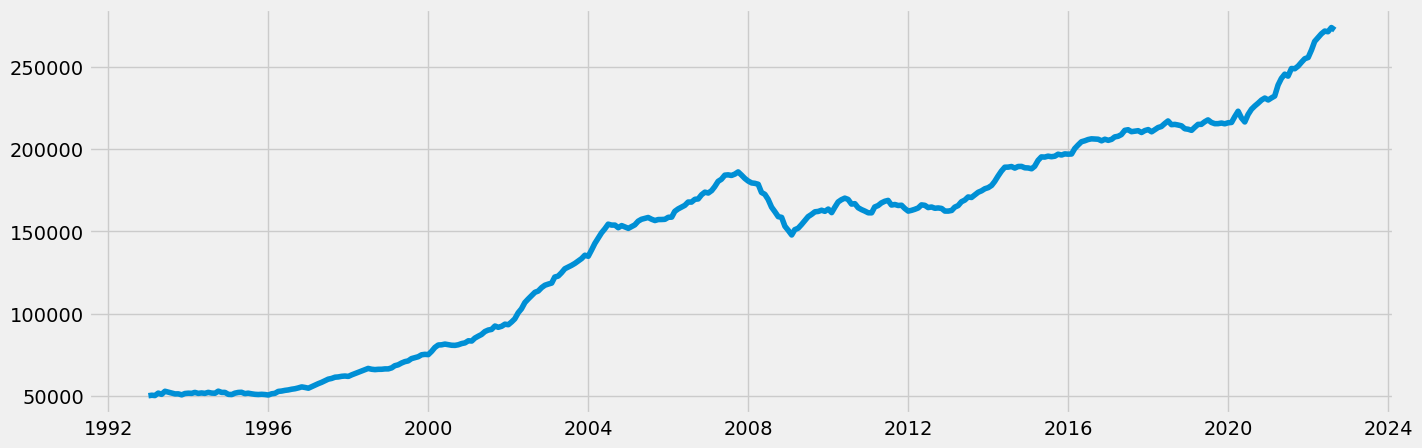

In [13]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 
plt.plot(house_price)

#### There is an uptrend in average house prices from 1992 to 2022.
#### There was a light drop after 2008, maybe due to the global economic crisis, but the price recovered and increased gradually from 2009 until now
#### The price is collected monthly, so smoothing is unnecessary.

In [14]:
# Check for missing values
house_price.isnull().sum() 

Avg_price    0
dtype: int64

In [15]:
# Check for duplicates
dups = house_price.duplicated()
dups.sum()
# No dups!

0

## 03. Time series analysis: decomposition

In [16]:
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(house_price, model='additive')

In [17]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

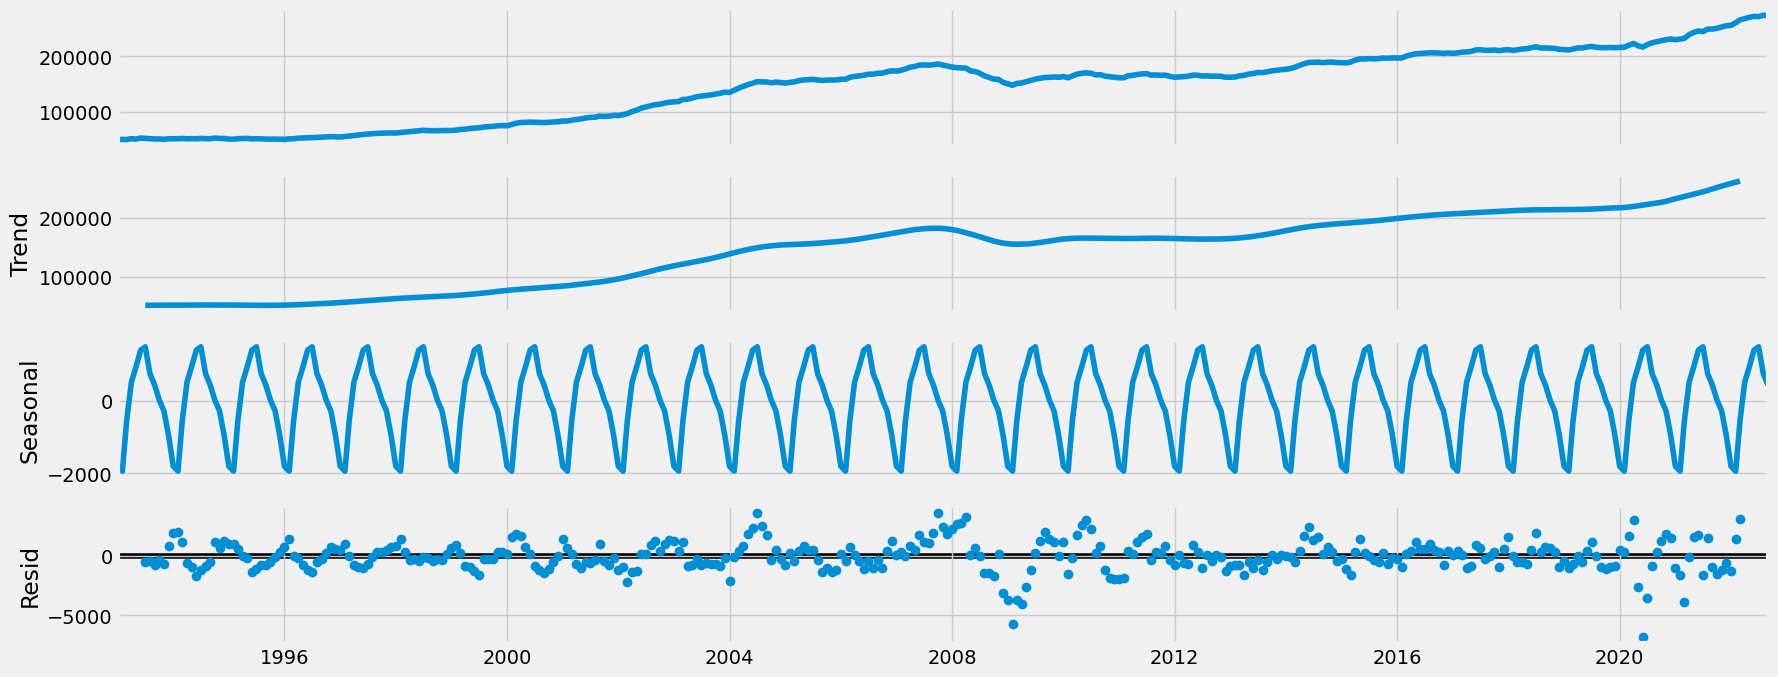

In [18]:
# Plot the separate components

decomposition.plot()
plt.show()

#### Trend and level have a similar pattern; this proves the data is smooth.
#### The trend in the chart above gradually increases linearly after 1996. While there was one drop around 2009, likely due to the global financial crisis, the overall trend continued to grow until the present year. This is the dominant trend in UK house prices.
#### There are seasonal fluctuations represented that change at a regular interval
#### There are many noises that do not affect the general trend.

## 04. Testing for stationarity

In [19]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(house_price['Avg_price'])

Dickey-Fuller Stationarity test:
Test Statistic                   0.061086
p-value                          0.963302
Number of Lags Used             15.000000
Number of Observations Used    341.000000
Critical Value (1%)             -3.449673
Critical Value (5%)             -2.870053
Critical Value (10%)            -2.571306
dtype: float64


#### My test statistic is much higher than the critical value at the five and ten percent significance levels. This means I cannot reject the null hypothesis and, as a result, consider the series non-stationary.

## 05. Stationarizing the Federal Reserve Economic Data

In [20]:
price_diff = house_price - house_price.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [21]:
price_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 

In [22]:
price_diff.head()

,Avg_price
Datetime,
1993-02-01,299.194286
1993-03-01,-187.323986
1993-04-01,1489.882286
1993-05-01,-776.144386
1993-06-01,1884.625980


In [23]:
price_diff.columns

Index(['Avg_price'], dtype='object')

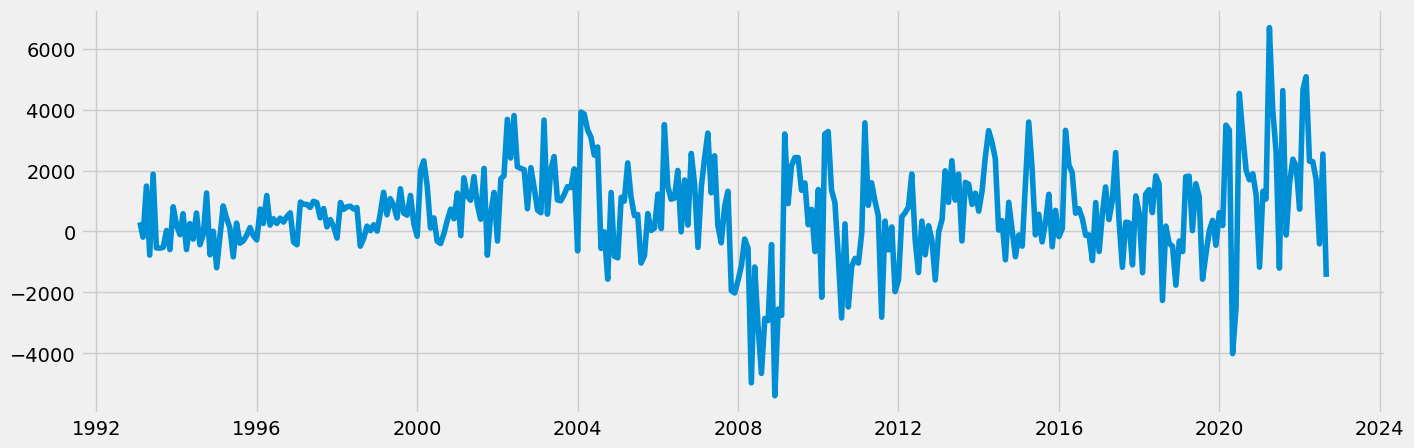

In [24]:
# Check out what the differencing did to the time-series curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(price_diff)

In [25]:
dickey_fuller(price_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -4.307717
p-value                          0.000431
Number of Lags Used             14.000000
Number of Observations Used    341.000000
Critical Value (1%)             -3.449673
Critical Value (5%)             -2.870053
Critical Value (10%)            -2.571306
dtype: float64


#### My test statistic is now lower than the critical value at the five and ten percent significance levels. I also have the p-value < 0.05. This means I can finally reject the null hypothesis and, as a result, consider my series stationary.

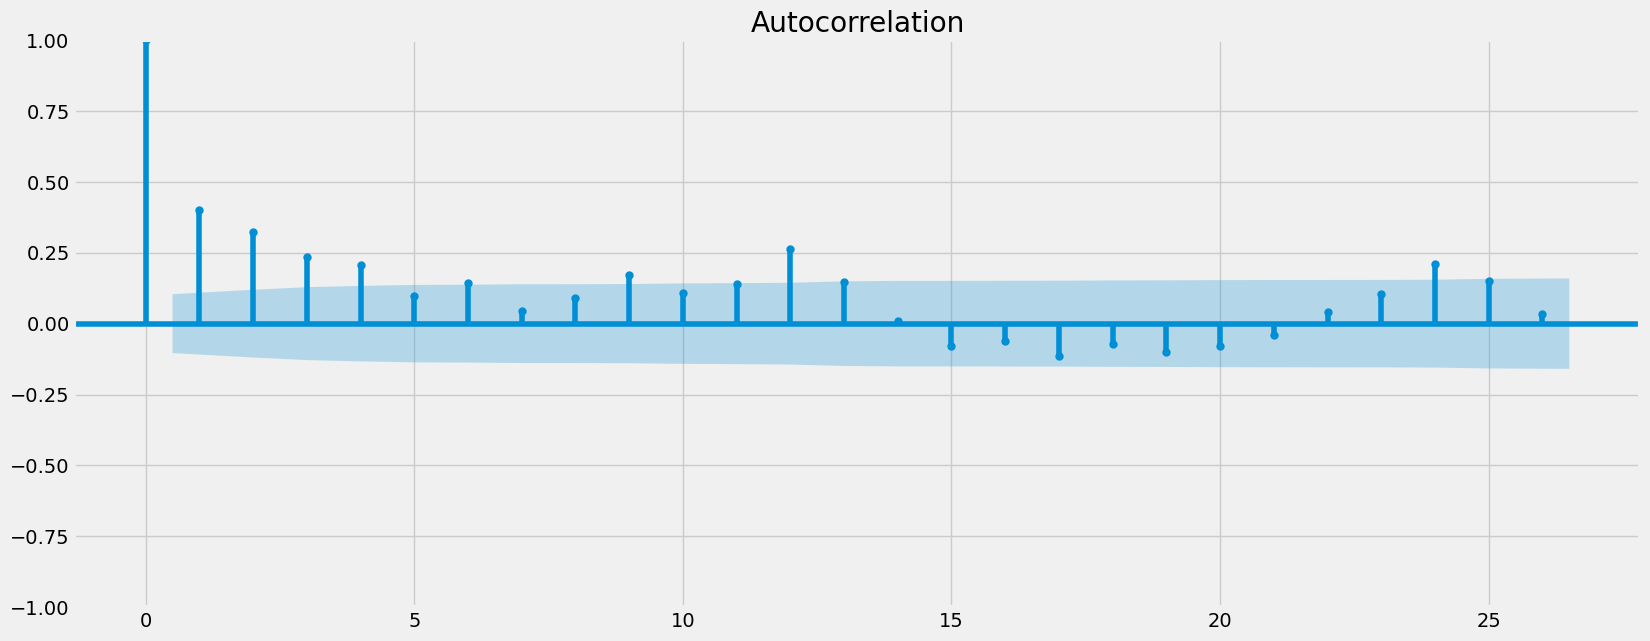

In [26]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(price_diff)
plt.show()

#### Despite the Dickey-Fuller test saying that my data is stationary, that stationarity is weak because the autocorrelation plot is still not perfect (all lines included in the confidence interval)

## 06. Defining Your Parameters

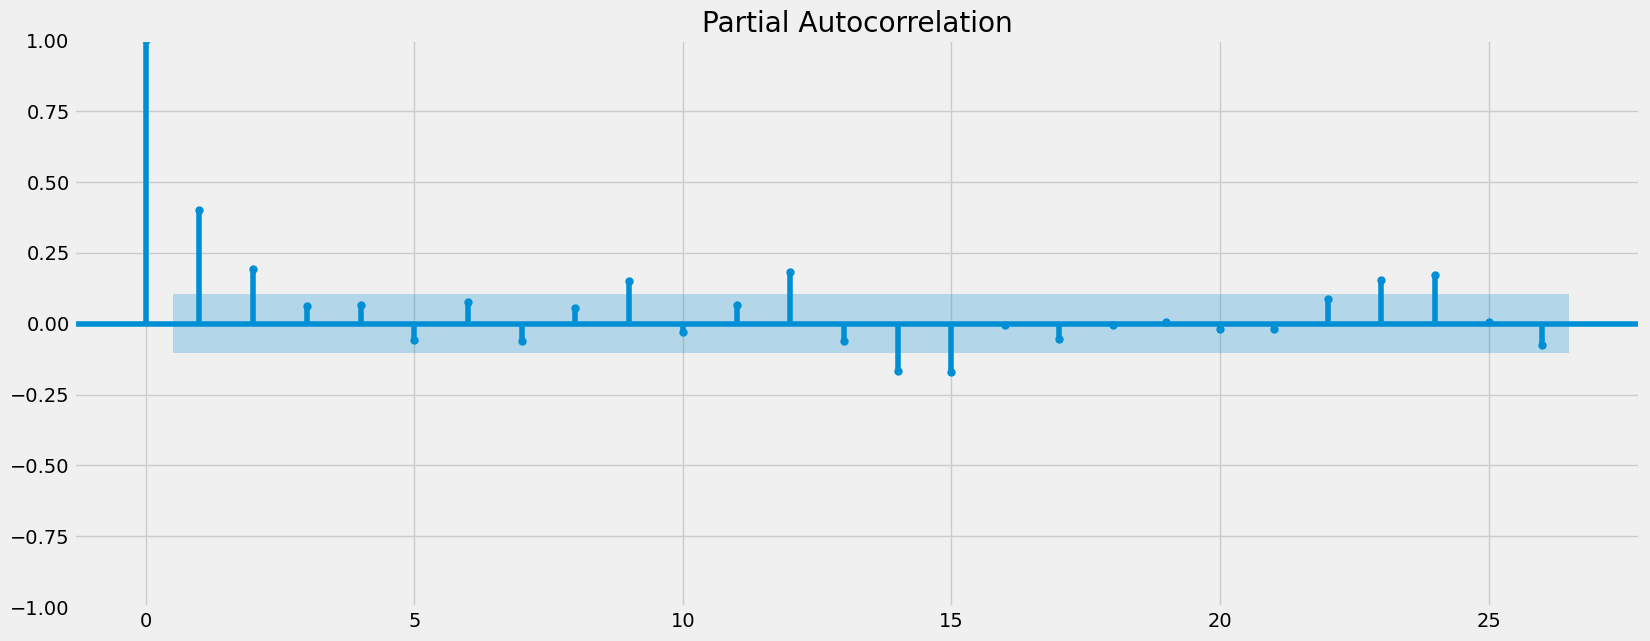

<Figure size 4500x4500 with 0 Axes>

In [27]:
# Plot partial autocorrelations to determine parameter p

plot_pacf(price_diff)
plt.figure(figsize=(15,15), dpi=300)
plt.show()

#### From the partial autocorrelation grapth, we can start with 1 for parameter p
#### From the autocorrelation graph, we can chose 3 for parameter q

## 07. Splitting the Data

In [28]:
# Split the data

train = price_diff['Avg_price'][:217]
test = price_diff['Avg_price'][216:] # split the data right after the effect of the global financial crisis started wearing off around 2010/2011
# and check how  accurately the model predicts

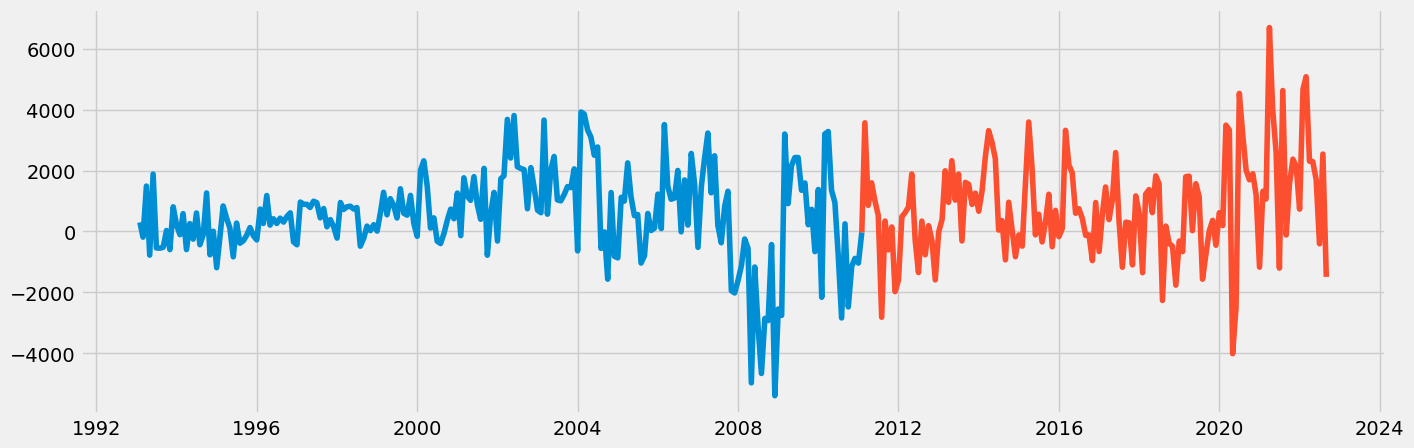

In [29]:
# Plot both sets in order to see the split

plt.figure(figsize=(15,5), dpi=100)
plt.plot(train)
plt.plot(test)

In [30]:
test.shape

(140,)

## 08. Running and Fitting the Model

In [31]:
from statsmodels.tsa.api import ARIMA # Import the model you need

                               SARIMAX Results                                
Dep. Variable:              Avg_price   No. Observations:                  217
Model:                 ARIMA(1, 1, 3)   Log Likelihood               -1838.861
Date:                Tue, 30 Apr 2024   AIC                           3687.722
Time:                        23:30:42   BIC                           3704.598
Sample:                    02-01-1993   HQIC                          3694.540
                         - 02-01-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7367      0.100      7.382      0.000       0.541       0.932
ma.L1         -1.4299      0.113    -12.662      0.000      -1.651      -1.209
ma.L2          0.6403      0.113      5.677      0.0

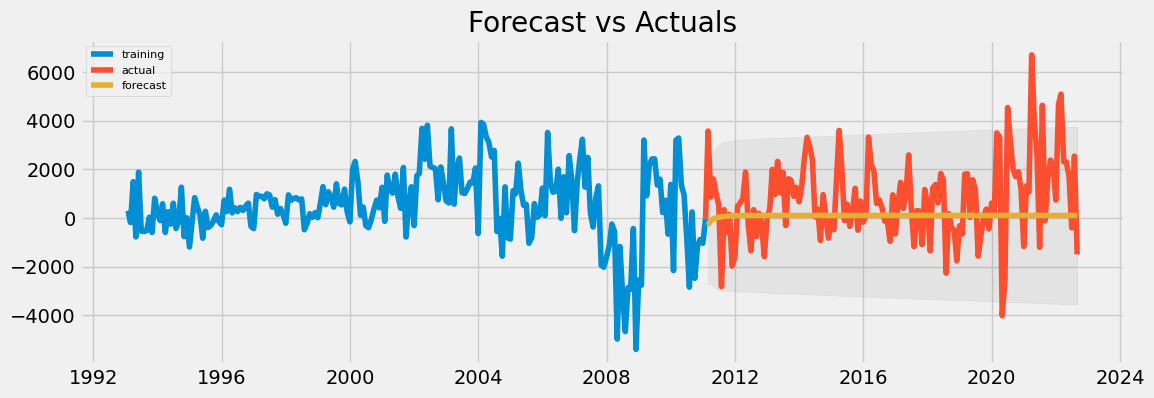

In [39]:
model = ARIMA(train, order=(1, 1, 3))  
fitted = model.fit()  
print(fitted.summary()) # Check model summary

# Forecast
forecast_steps = 140  # Number of steps to forecast
fc = fitted.forecast(steps=forecast_steps)  # Forecast

# Calculate standard errors manually
se = fitted.get_forecast(steps=forecast_steps).se_mean

# Calculate confidence intervals manually
conf_int = 1.96 * se  # 95% confidence interval

# Make into pandas series
fc_series = pd.Series(fc, index=test.index)  # This creates the forecasted curve
lower_series = pd.Series(fc - conf_int, index=test.index)  # Lower bound of the confidence interval
upper_series = pd.Series(fc + conf_int, index=test.index)  # Upper bound of the confidence interval

# Plot
plt.figure(figsize=(12, 4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.05)  # This creates the confidence interval
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


#### The statistically significant coefficients suggest that past price differences and past forecast errors influence the current price difference.
#### However, the visual shows that the forecast line does not match the actual values at all, which seems that my model does not fit and works effectively.